# **Train Face Segmentation Model**

Here I train the face segmentation model used for this [streamlit app](https://custom-xmas-decoration.streamlit.app/).

The main difficulty was actually processing the RGB facemasks into 2-d tensor-masks that contained integers depending on which part of the face that pixel was a part of.

I ran this notebook on a cloud-gpu platform hence the `!pip` commands. 

#### **Data**
[Link](https://store.mut1ny.com/product/face-head-segmentation-dataset-community-edition?v=6048de06ffbd) to the dataset.

This dataset is openly available for non commercial purposes.

When the user downloads the dataset there are many generated images not of interest for our training of the model. Thus to run this notebook they should:
1. Create an empty folder called `face_data/` in the working directory.
2. Into this directory copy and past the folder `real_photos/` from the downloaded dataset.
3. Also copy and past the folder `labels/real/` as `labels_real/` from the downloaded dataset.



In [1]:
!pip install -Uq fastai
!pip install -Uq nbdev

In [1]:
from fastai.vision.all import *
from pathlib import Path

### **Create 2d Labels from the Original RGB Masks**

In [3]:
# Define the directory name
directory_name = "face_data"

# Get the current working directory
current_directory = Path.cwd()

# Construct the path to the 'face_data' directory
path = current_directory / directory_name

In [5]:
labelsnames = get_image_files(path / "labels_real")
labelsnames[0]

Path('/notebooks/xmas-bauble-face/face_data/labels_real/osho_seq2_7751_scaled.png')

In [6]:
# define the codes that link an RGB combination to a facial features
codes = np.array(
    [
        "Background",
        "Lips/mouth",
        "Eyes",
        "Nose",
        "General face/head",
        "hair",
        "eyebrows",
        "ears",
        "teeth",
        "facial hair/beard",
        "specs/sunglasses",
    ]
)

# the indices of codes is given by the combination of colours!
label_colors = {
    (0, 0, 0): 0,
    (255, 0, 0): 1,
    (0, 255, 0): 2,
    (0, 0, 255): 3,
    (128, 128, 128): 4,
    (255, 255, 0): 5,
    (255, 0, 255): 6,
    (0, 255, 255): 7,
    (255, 255, 255): 8,
    (255, 192, 192): 9,
    (0, 128, 128): 10,
}

In [7]:
# I need to convert the 3 layer RGB tensor into a single layer tensor
def pictures_to_label(img_tensor, label_colors):
    # Create a flattened list of RGB values and corresponding labels
    rgb_values = torch.tensor([list(k) for k in label_colors.keys()])
    labels = torch.tensor([v for v in label_colors.values()])

    # Calculate a unique value for each RGB combination (kind of like converting to grayscale)
    # This is a simple weighted sum of the RGB values
    weights = torch.tensor([0.299, 0.587, 0.114])
    unique_rgb_values = (rgb_values * weights).sum(dim=1)

    # Do the same for each pixel in the image tensor
    img_rgb_values = (img_tensor * weights).sum(dim=2)

    # Now, for each unique value in the image, find the corresponding label
    label_img = torch.zeros_like(img_rgb_values, dtype=torch.long)
    for i, val in enumerate(unique_rgb_values):
        label_img[img_rgb_values == val] = labels[i]

    return label_img

In [8]:
# this creates a new folder with the desired image labels in 2d tensor form
def create_label_folder(
    labelsnames, label_colors, destination_folder="labels_real_mask"
):
    for label_path in labelsnames:
        img = PILImage.create(label_path)
        img_tensor = tensor(img)

        img_label_tensor = pictures_to_label(img_tensor, label_colors)

        # Ensure the tensor is of type uint8
        img_label_tensor = img_label_tensor.to(torch.uint8)

        pil_img = Image.fromarray(img_label_tensor.numpy())

        new_label_path = label_path.parent.parent / destination_folder / label_path.name

        print(label_path.name)
        pil_img.save(new_label_path)

In [12]:
create_label_folder(labelsnames, label_colors)

Some useful links:
- Useful notes on [masks](https://docs.fast.ai/vision.core.html#PILImage.create).
- [Resize](https://docs.fast.ai/vision.augment.html#resize) documentation.

### Now Create DataLoader

In [9]:
fnames = get_image_files(path / "real_photos")
fnames[0]

Path('/notebooks/xmas-bauble-face/face_data/real_photos/osho_seq2_7751_scaled.png')

In [10]:
(path / "labels_real_mask").ls()[0]

Path('/notebooks/xmas-bauble-face/face_data/labels_real_mask/osho_seq2_7751_scaled.png')

In [11]:
# The new non RGB labels are saved as .png, some of the original images are
# .jpg, so need to be renamed when finding their masks!
def label_func(fn):
    return path / "labels_real_mask" / f"{fn.name[:-3]}png"

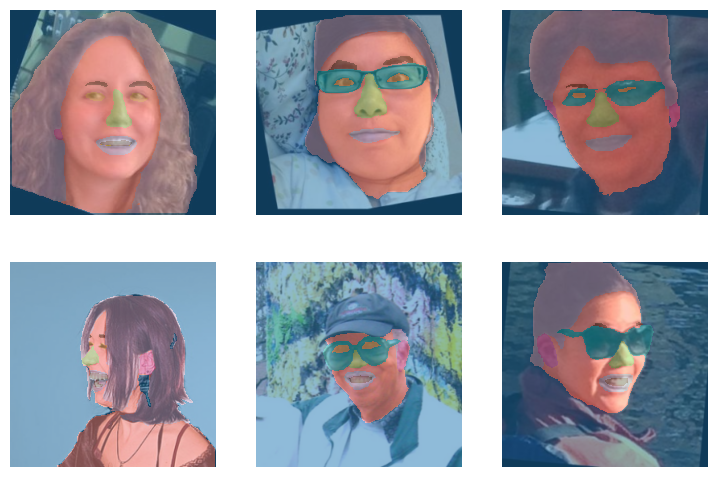

In [12]:
# Create item transforms with Resize
item_transforms = [Resize(256)]

# Create the DataLoaders with the item transforms
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=8,
    fnames=fnames,
    label_func=label_func,
    codes=codes,
    item_tfms=item_transforms,
)

# Now try to show a batch
dls.show_batch(max_n=6)

## **Train Model**

In [13]:
learn = unet_learner(dls, resnet18)

learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,0.686445,0.898125,01:19


epoch,train_loss,valid_loss,time
0,0.396507,0.369724,01:22


SuggestedLRs(valley=5.248074739938602e-05)

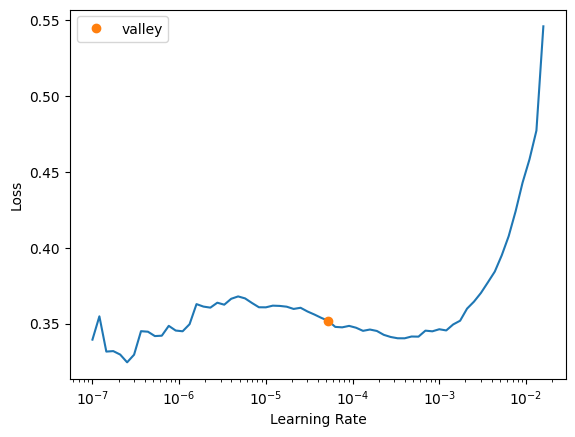

In [14]:
learn.lr_find()

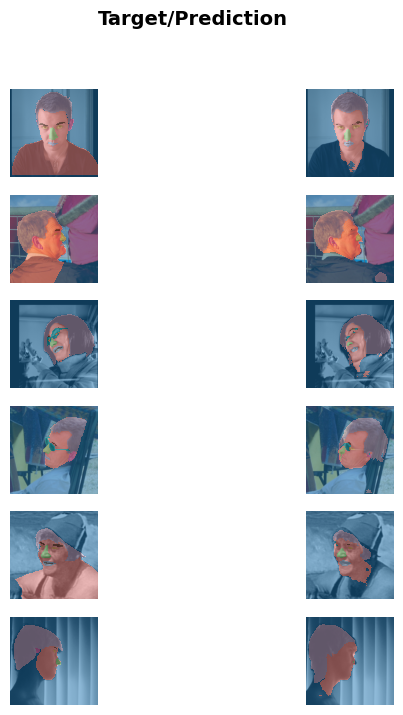

In [15]:
learn.show_results(max_n=6, figsize=(7, 8))

In [37]:
learn.lr = 0.0001

In [38]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,0.387336,0.409481,01:25


epoch,train_loss,valid_loss,time
0,0.311075,0.334948,01:28
1,0.265198,0.306548,01:28
2,0.196982,0.313181,01:29


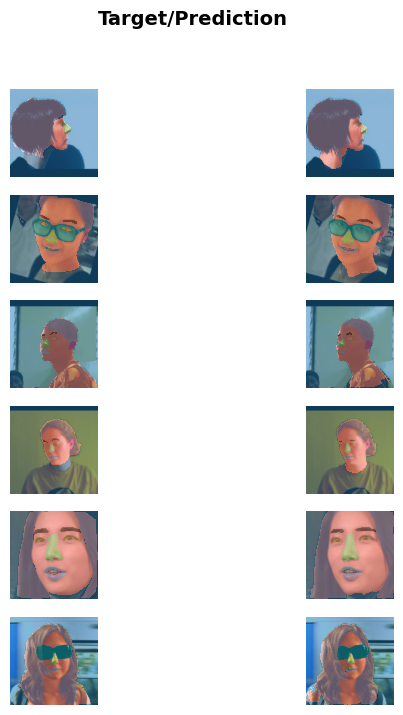

In [39]:
learn.show_results(max_n=6, figsize=(7, 8))

In [40]:
# export the model, this will be used within the streamlit app
learn.export("v1_model.pkl")

## **Now Make Some Predictions**

In [5]:
model = load_learner("testing_photos/v1_model.pkl")

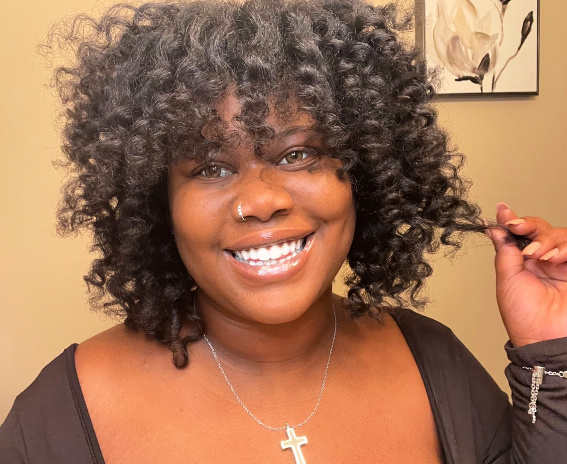

<AxesSubplot: >

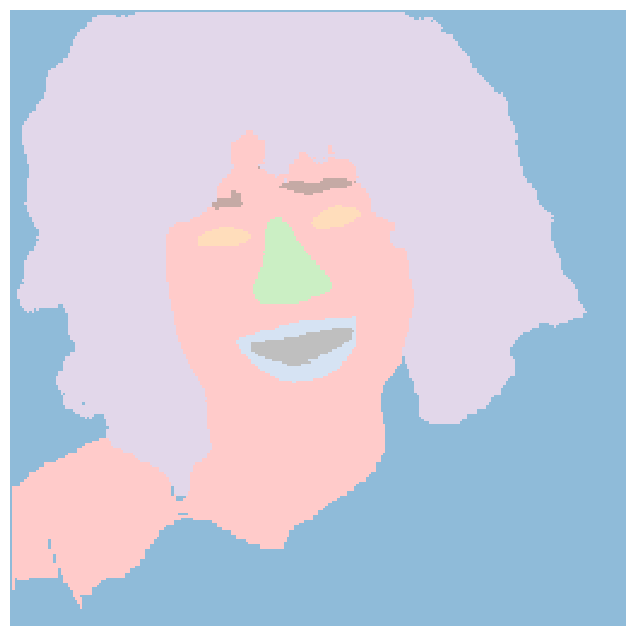

In [8]:
img = load_image("testing_photos/person.jpg")
img.show()
prediction = model.predict(img)
prediction_mask = prediction[0]
prediction_mask.show(figsize=(8, 8))

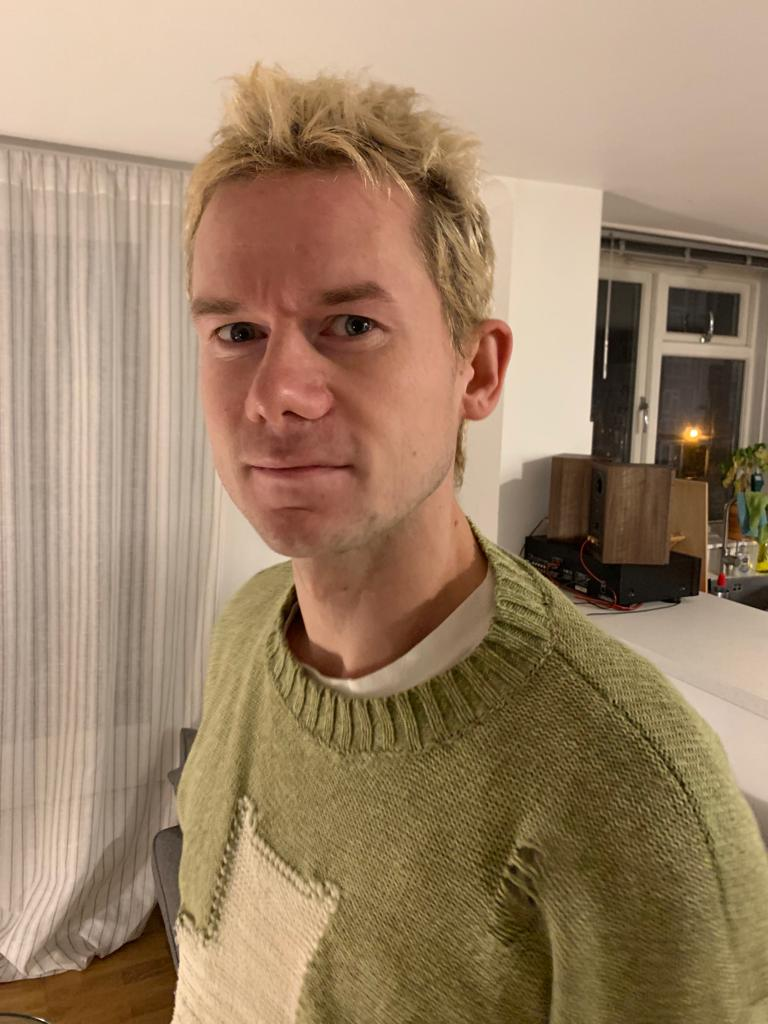

<AxesSubplot: >

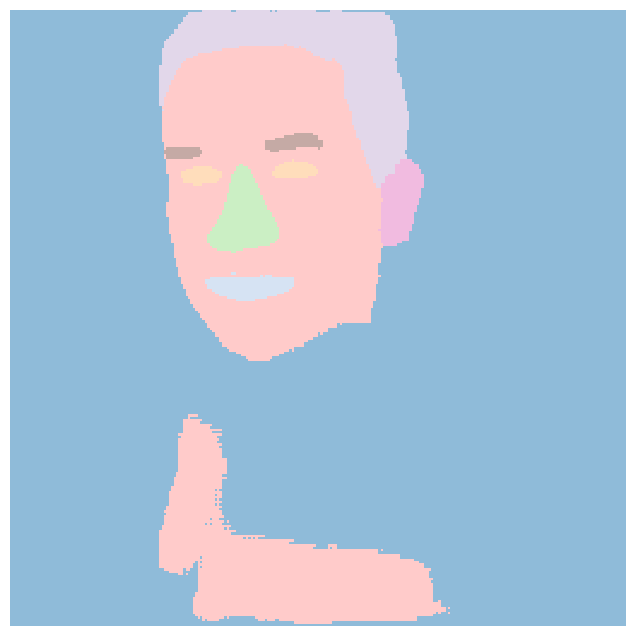

In [83]:
img = load_image("johnny.jpeg")
img.show()
prediction = model.predict(img)
prediction_mask = prediction[0]
prediction_mask.show(figsize=(8, 8))